In [1]:
# Create data frame of screening data

import os, glob
import pandas as pd

data_list = []

path = 'data'
for filename in glob.glob(os.path.join(path, '*.txt')):
    with open(os.path.join(os.getcwd(), filename), 'r') as file:
        for line in file.readlines():
            newline = line.strip('\n')
            data_list.append(newline)

data_list2 = data_list[:2]

for i in range(3, len(data_list), 2):
    data_list2.append(data_list[i])

data_list3 = []

for line in data_list2:
    sub_list = line.split('\t')
    data_list3.append(sub_list)

df_raw = pd.DataFrame(data_list3[1:], columns=data_list3[0])

In [2]:
def MutationClass(wt_seq, mt_seq):
    
    '''Identifying mutation class
    inputs are wildtype and mutant sequences, both are strings
    output is a mutation class, string
    '''
    
    if len(wt_seq) != len(mt_seq):
        if len(wt_seq) > len(mt_seq):
            mutation = 'Deletion'
        else:
            mutation = 'Insertion'
    
    else:
        for pos in range(len(wt_seq)):
            if wt_seq[pos] != mt_seq[pos]:
                mutation = 'Substitution'
            
    return mutation

In [3]:
def MutationLoc(wt_seq, mt_seq):
    
    '''Identifying mutation location
    inputs are wildtype and mutant sequences, both are strings
    output is a mutation position (Promoter, CDS, Both), string
    '''
    
    if len(mt_seq) <= 1000:
        if mt_seq != wt_seq:
            loc = "Promoter"
    else:
        if mt_seq[:1000] != wt_seq[:1000]:
            loc = "Promoter"
        elif mt_seq[:1000] == wt_seq[:1000] and mt_seq[1000:] != wt_seq[1000:]:
            loc = "CDS"
        elif mt_seq[:1000] == wt_seq[:1000] and mt_seq[1000:] == wt_seq[1000:]:
            loc = "No mutation"
    return loc
        

In [4]:
def avg(gene, value):
    
    '''Calculate mean
    input1 is an index of gene row, int
    input2 is a name of the value (header) without ".Rep1/2/3", string
    output is mean, float
    '''
    
    if type(gene) != int:
        raise AttributeError("{} is an incorrect data format - must be int".format(type(gene)))
    elif type(value) != str:
        raise AttributeError("{} is an incorrect data format - must be str".format(type(value)))
        
    reps = []
    for rep in range(3):
        reps.append(float(df_raw.loc[gene, value+".Rep"+str(rep+1)]))
    
    return sum(reps)/len(reps)

In [5]:
def CellViaChange(wt_cellvia, mt_cellvia):
    
    '''
    Calculate percentage of cell viability change
    inputs are cell viability of wild type and mutant, float
    output is percentage of cell viability change, float
    '''
    
    percentChange = (abs(wt_cellvia - mt_cellvia)/wt_cellvia) * 100
    
    return percentChange

In [6]:
# Identify mutation class

mut_class = []
for gene in range(len(df_raw)):
    mut_class.append(MutationClass(df_raw.loc[gene, "WildType.Sequence"], df_raw.loc[gene, "Mutant.Sequence"]))


In [7]:
# Identify mutation location

mut_loc = []
for gene in range(len(df_raw)):
    mut_loc.append(MutationLoc(df_raw.loc[gene, "WildType.Sequence"], df_raw.loc[gene, "Mutant.Sequence"]))


In [8]:
# Calculate mean mRNA expression wild type

wt_mean_mRNA = []
for gene in range(len(df_raw)):
    wt_mean_mRNA.append(avg(gene, "mRNA.Expression.WT"))


In [9]:
# Calculate mean mRNA expression mutant

mut_mean_mRNA = []
for gene in range(len(df_raw)):
    mut_mean_mRNA.append(avg(gene, "mRNA.Expression.Mut"))


In [10]:
# Calculate mean protein expression wild type

wt_mean_protein = []
for gene in range(len(df_raw)):
    wt_mean_protein.append(avg(gene, "Protein.Expression.WT"))


In [11]:
# Calculate mean protein expression mutant

mut_mean_protein = []
for gene in range(len(df_raw)):
    mut_mean_protein.append(avg(gene, "Protein.Expression.Mut"))


In [12]:
# Calculate mean cell viability wild type

wt_mean_cellvia = []
for gene in range(len(df_raw)):
    wt_mean_cellvia.append(avg(gene, "CellViability.WT"))


In [13]:
# Calculate mean cell viability mutant

mut_mean_cellvia = []
for gene in range(len(df_raw)):
    mut_mean_cellvia.append(avg(gene, "CellViability.Mut"))


In [14]:
# Create summary table

# Create the first column = gene name
gene_list = [["Gene"]]
for gene in range(len(df_raw)):
    gene_list.append([df_raw.loc[gene, "Gene"]])
    
df_summary = pd.DataFrame(gene_list[1:], columns=gene_list[0])

# Add other columns
df_summary.insert(1, "Mutation Class", mut_class, True)
df_summary.insert(2, "Mutation Location", mut_loc, True)
df_summary.insert(3, "mRNA.Expression.WT.Mean", wt_mean_mRNA, True)
df_summary.insert(4, "mRNA.Expression.Mut.Mean", mut_mean_mRNA, True)
df_summary.insert(5, "Protein.Expression.WT.Mean", wt_mean_protein, True)
df_summary.insert(6, "Protein.Expression.Mut.Mean", mut_mean_protein, True)
df_summary.insert(7, "CellViability.WT.Mean", wt_mean_cellvia, True)
df_summary.insert(8, "CellViability.Mut.Mean", mut_mean_cellvia, True)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sbn

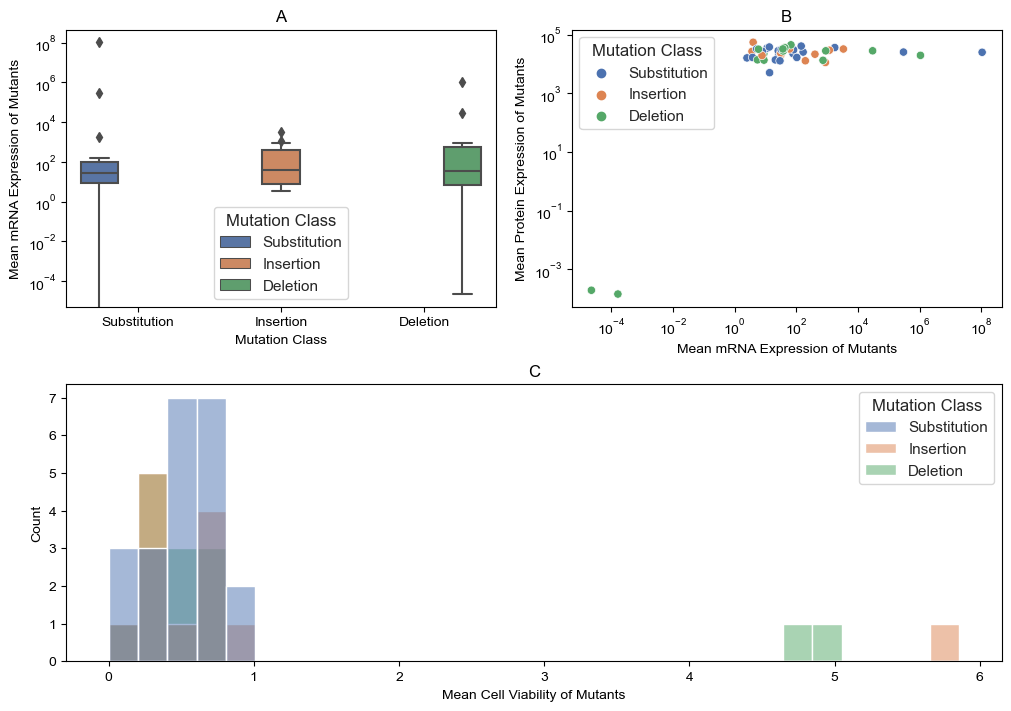

In [16]:
# Plot effects of mutation class graphs

fig, ax = plt.subplot_mosaic([["box", "scatter"],["hist", "hist"]], 
                             figsize=(10, 7), layout="constrained")
sbn.set(font_scale=1)
sbn.set_style(style='white')

# boxplot
sbn.boxplot(df_summary, x="Mutation Class", y="mRNA.Expression.Mut.Mean", hue="Mutation Class", ax=ax["box"])
ax["box"].set_yscale("log")
ax["box"].set_ylabel("Mean mRNA Expression of Mutants")
ax["box"].set_title("A")

# scatter plot
sbn.scatterplot(df_summary, x="mRNA.Expression.Mut.Mean", y="Protein.Expression.Mut.Mean", hue="Mutation Class", ax=ax["scatter"])
ax["scatter"].set_yscale("log")
ax["scatter"].set_xscale("log")
ax["scatter"].set_ylabel("Mean Protein Expression of Mutants")
ax["scatter"].set_xlabel("Mean mRNA Expression of Mutants")
ax["scatter"].set_title("B")

# histogram
sbn.histplot(df_summary, x="CellViability.Mut.Mean", hue="Mutation Class", ax=ax["hist"])
ax["hist"].set_xlabel("Mean Cell Viability of Mutants")
ax["hist"].set_title("C")
plt.show()

In [17]:
# Calculate cell viability change

cellvia_change = []
for gene in range(len(df_raw)):
    cellvia_change.append(CellViaChange(df_summary.loc[gene, "CellViability.WT.Mean"], df_summary.loc[gene, "CellViability.Mut.Mean"]))


In [18]:
# Add cell viability change into summary table

df_summary.insert(9, "Cell Viability Change", cellvia_change, True)


In [19]:
# Top 5 Mutants (Gene Of Interest)

GOI = [3, 7, 26, 37, 39]

In [20]:
# make data frame for heatmap

heat_list = [["Gene", "Genotype", "mRNA Expression", "Protein Expression"]]

for gene in range(len(df_summary)):
    sublist = [df_summary.loc[gene, "Gene"], "Wild Type", float(df_summary.loc[gene, "mRNA.Expression.WT.Mean"]), float(df_summary.loc[gene, "Protein.Expression.WT.Mean"])]
    heat_list.append(sublist)
    sublist = [df_summary.loc[gene, "Gene"], "Mutant", float(df_summary.loc[gene, "mRNA.Expression.Mut.Mean"]), float(df_summary.loc[gene, "Protein.Expression.Mut.Mean"])]
    heat_list.append(sublist)

print(heat_list)


df_rnaP = pd.DataFrame(heat_list[1:], columns=heat_list[0])

[['Gene', 'Genotype', 'mRNA Expression', 'Protein Expression'], ['Ah3', 'Wild Type', 106104500.41802746, 25176.666666666668], ['Ah3', 'Mutant', 106104501.50114878, 25184.0], ['Alli2r', 'Wild Type', 400.5105851486068, 21626.666666666668], ['Alli2r', 'Mutant', 400.4838525917398, 21637.666666666668], ['Alli8', 'Wild Type', 27.657171381769402, 20556.333333333332], ['Alli8', 'Mutant', 26.928329569363996, 20565.333333333332], ['Anap7c1', 'Wild Type', 9.95771022732623, 21147.666666666668], ['Anap7c1', 'Mutant', -39.57047711670045, 10071.333333333334], ['App1l8', 'Wild Type', 4.057949182286905, 26965.333333333332], ['App1l8', 'Mutant', 3.632352909966963, 26974.0], ['App8', 'Wild Type', 2.4354714775300628, 16175.666666666666], ['App8', 'Mutant', 2.4978338861211, 16183.0], ['Avon1a5', 'Wild Type', 77.14529910702257, 22752.333333333332], ['Avon1a5', 'Mutant', 77.51793135230538, 22765.666666666668], ['Avon4', 'Wild Type', 2.5127897199430618, 35318.333333333336], ['Avon4', 'Mutant', 3.9583555575027

In [21]:
# Retrieve GOI data from heatmap data frame

GOI_2 = [i*2 for i in GOI]
for i in GOI:
    GOI_2.append(i*2+1)

print(GOI_2)

print(df_rnaP.iloc[GOI_2])

[6, 14, 52, 74, 78, 7, 15, 53, 75, 79]
       Gene   Genotype  mRNA Expression  Protein Expression
6   Anap7c1  Wild Type         9.957710        21147.666667
14    Avon4  Wild Type         2.512790        35318.333333
52   Ist9a2  Wild Type      5010.362712           23.961963
74  Nect1c1  Wild Type         9.645300        30209.666667
78   Oyu3a9  Wild Type     13830.139806          896.525042
7   Anap7c1     Mutant       -39.570477        10071.333333
15    Avon4     Mutant         3.958356        55350.000000
53   Ist9a2     Mutant         0.000022            0.000191
75  Nect1c1     Mutant         8.901433        13595.666667
79   Oyu3a9     Mutant         0.000162            0.000142


In [22]:
min([rnaX for rnaX in [df_rnaP.loc[gene, "mRNA Expression"] for gene in GOI_2]])

-39.57047711670045

In [23]:
max([rnaX for rnaX in [df_rnaP.loc[gene, "mRNA Expression"] for gene in GOI_2]])

13830.139805753368

In [24]:
min([pX for pX in [df_rnaP.loc[gene, "Protein Expression"] for gene in GOI_2]])

0.00014156287451357646

In [25]:
max([pX for pX in [df_rnaP.loc[gene, "Protein Expression"] for gene in GOI_2]])

55350.0

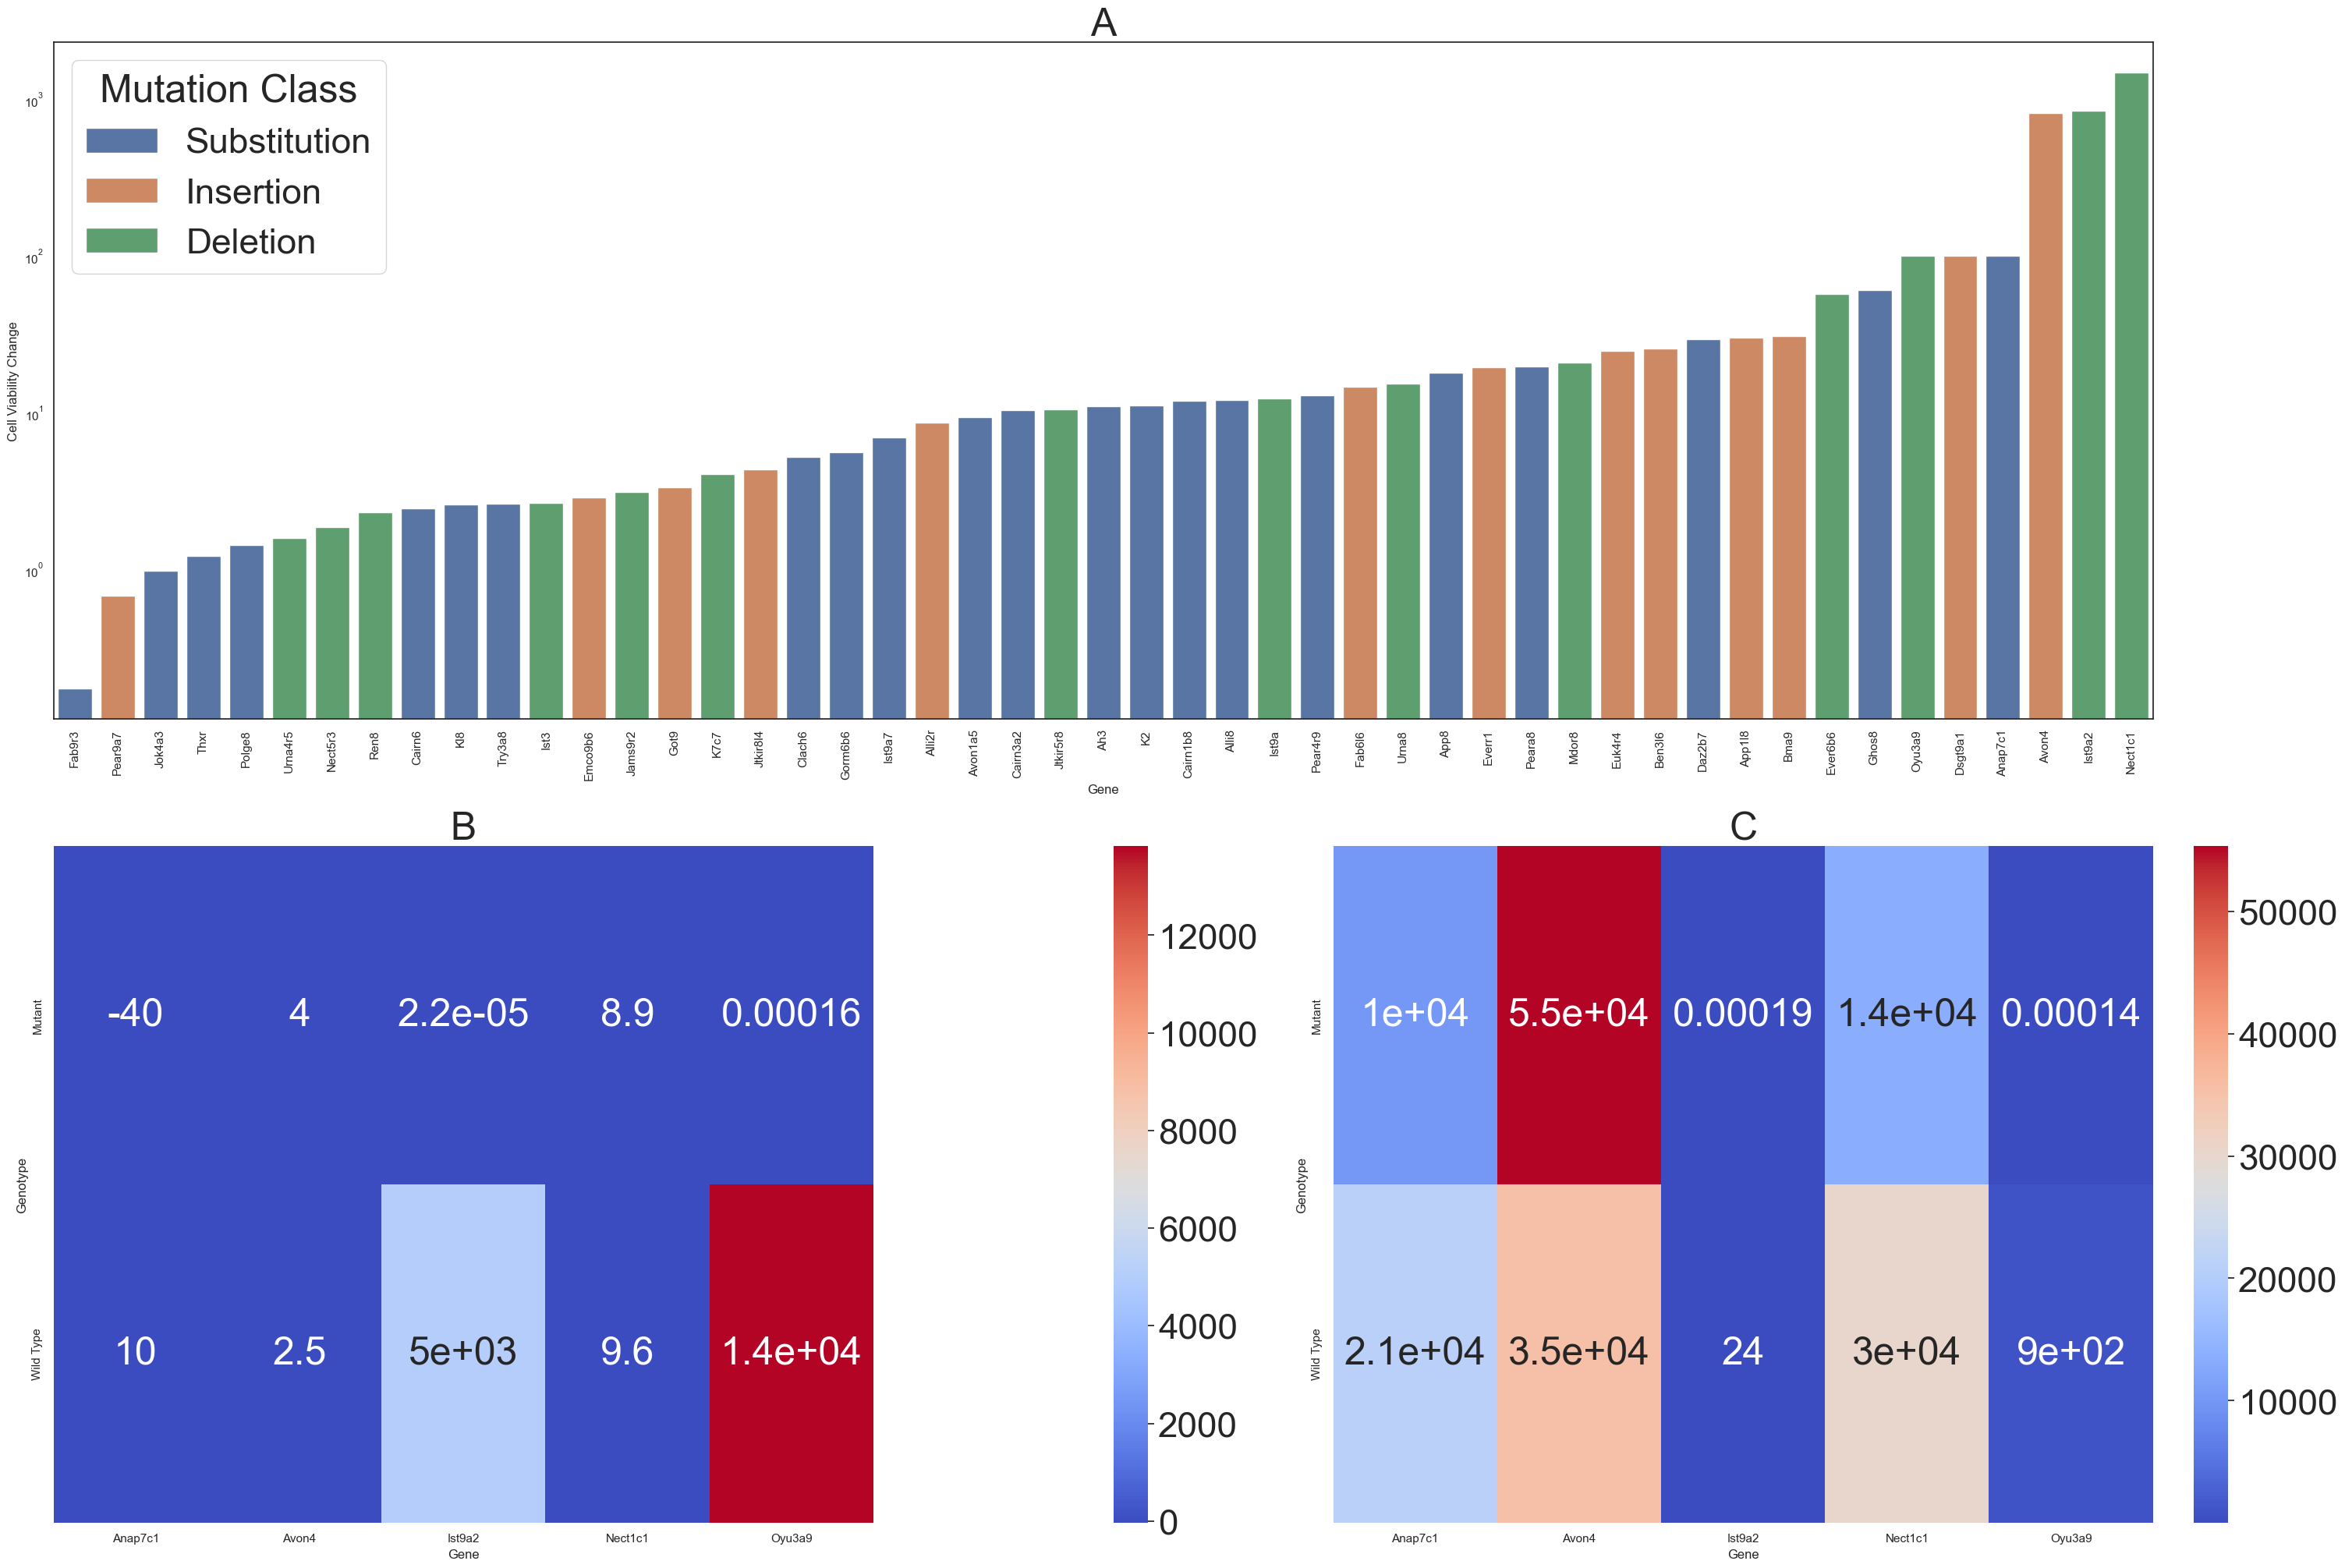

In [26]:
# Plot prioritisation analysis graphs

fig, ax = plt.subplot_mosaic([["bar", "bar"],["mRNA", "protein"]], 
                             figsize=(30, 20), layout="constrained")

sbn.set(font_scale=3)
sbn.set_style(style='white') 

# sort df by Cell Viability Change column
df_summary_cellviaSort = df_summary.sort_values(['Cell Viability Change']).reset_index(drop=True)


# bar chart
sbn.barplot(data=df_summary_cellviaSort, x="Gene", y="Cell Viability Change", hue="Mutation Class", dodge=False, ax=ax["bar"])
ax["bar"].set_title("A")
ax["bar"].set_xticklabels(ax["bar"].get_xticklabels(), rotation=90)
ax["bar"].set_yscale("log")


# mRNA heatmap
heat_mRNA_GOI = df_rnaP.iloc[GOI_2].pivot(index="Genotype", columns="Gene", values="mRNA Expression")
sbn.heatmap(heat_mRNA_GOI, vmin=-39.57047711670045, vmax=13830.139805753368, annot=True, cmap="coolwarm", ax=ax["mRNA"])
ax["mRNA"].set_title("B")

# make a protein heatmap
heat_P_GOI = df_rnaP.iloc[GOI_2].pivot(index="Genotype", columns="Gene", values="Protein Expression")
sbn.heatmap(heat_P_GOI, vmin=0.00014156287451357646, vmax=55350.0, annot=True, cmap="coolwarm", ax=ax["protein"])
ax["protein"].set_title("C")


plt.show()